## Задание

Попробуйте повысить точность нашей модели:

- увеличьте количество эпох;
- увеличьте количество нейронов;
- добавьте новые скрытые слои;
- измените размер мини-пакета.

При желании придумайте, как визуализировать работу модели на тестовых данных (показывать изображения и соответствующий им распознанный класс).

In [37]:
import numpy as np

import torch
import torch.nn as nn
from torch import optim, nn
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [38]:
def make_train_step(model, loss_fn, optimizer):
    def train_step(x, y):
        model.train()
        yhat = model(x)
        loss = loss_fn(yhat, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return loss.item()
    return train_step


def plot_learning_curve(loss_array: list):
    plt.figure(figsize=(8, 4))
    plt.plot(range(len(loss_array)), loss_array)
    plt.title('Learning curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

In [5]:
# Configs
INPUT_SIZE = 28*28     # Размер изображения в точках
HIDDEN_SIZE = 500      # Количество нейронов в скрытом слое
NUM_CLASSES = 10       # Количество распознающихся классов (10 цифр)
N_EPOCHS = 2           # Количество эпох
BATCH_SIZE = 4         # Размер мини-пакета входных данных
LR = 0.01              # Скорость обучения

# инициализируем девайс
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
# Load dataset
mnist_trainset = dsets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_testset = dsets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
print(len(mnist_trainset))
print(len(mnist_testset))

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|███████████████████████████████████████████████████████████| 9912422/9912422 [16:42<00:00, 9891.04it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 32517.34it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████████████████████████| 1648877/1648877 [01:37<00:00, 16976.14it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 14248712.62it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

60000
10000


In [10]:
# загрузчик обучающих данных
train_loader = torch.utils.data.DataLoader(
    dataset=mnist_trainset,
    batch_size=BATCH_SIZE,
    shuffle=True
) 
# загрузчик тестовых данных
test_loader = torch.utils.data.DataLoader(
    dataset=mnist_testset,
    batch_size=BATCH_SIZE,
    shuffle=False
) 

## 3. Fit Model

### 3.1. Baseline

In [11]:
%time

model = torch.nn.Sequential(
    nn.Linear(INPUT_SIZE, HIDDEN_SIZE),
    nn.ReLU(),
    nn.Linear(HIDDEN_SIZE, NUM_CLASSES))
model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

train_step = make_train_step(model, loss_fn, optimizer)

for epoch in range(N_EPOCHS):
    for images, labels in train_loader:
        images = images.reshape(-1, 28*28).to(device)
        images = images.to(device)
        labels = labels.to(device)
        loss = train_step(images, labels)
    print(epoch)

print(model.state_dict())
print(loss)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.1 µs
0
1
OrderedDict([('0.weight', tensor([[-0.0345, -0.0115, -0.0192,  ..., -0.0181,  0.0271,  0.0326],
        [ 0.0045,  0.0270,  0.0309,  ...,  0.0045,  0.0232, -0.0043],
        [ 0.0115,  0.0191, -0.0295,  ..., -0.0041,  0.0121, -0.0233],
        ...,
        [-0.0082,  0.0249, -0.0137,  ..., -0.0118, -0.0335, -0.0226],
        [-0.0195,  0.0305,  0.0340,  ...,  0.0334,  0.0275,  0.0016],
        [-0.0314, -0.0256, -0.0268,  ...,  0.0337, -0.0183, -0.0303]],
       device='cuda:0')), ('0.bias', tensor([-8.7272e-02, -7.5779e-02, -7.4870e-02, -5.1203e-01, -2.7420e-01,
        -6.2386e-02, -1.3750e-01, -3.5392e-01, -8.0126e-02, -3.2120e-02,
        -2.1176e-01, -9.5897e-02, -3.4139e-02, -9.5141e-01, -5.4845e-01,
        -3.9295e-01, -1.0480e-01, -8.2005e-02, -7.2878e-02, -5.0986e-02,
        -3.9237e+00, -8.1039e-02, -1.9193e-01, -1.4298e-01, -1.3016e-01,
        -6.8146e-02, -4.4418e-01, -4.7477e-02, -7.5032e-02, -1.4601e+00

In [12]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Точность: {} %'.format(100 * correct / total))

Точность: 93.01 %


In [13]:
torch.save(model, 'models/baseline_mnist_full.pt')

In [ ]:
# model = torch.load("mnist_full.pt")
# model.eval() # После загрузки модели надо обязательно выполнить её метод eval() -- это означает, что мы будем пользоваться моделью в режиме её эксплуатации, а не в режимах обучения или каких-то других.

### 3.2. Experiments

Попробуем улучшить существующую модель, поработав со следующими параметрами:

- увеличьте количество эпох;
- увеличьте количество нейронов;
- добавьте новые скрытые слои;
- измените размер мини-пакета.

#### Модифицированный baseline

Начнём с того, что постараемся улучшить наш baseline

In [41]:
class BaselineMNISTModel(nn.Module):
    def __init__(self, input_size: int, hidden_size: int):
        super(BaselineMNISTModel, self).__init__()
        self.seq = torch.nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 10)
        )

    def forward(self, x):
        return self.seq(x)

In [42]:
# Params
INPUT_SIZE = 28*28
HIDDEN_SIZE = 500
N_EPOCHS = 20
LR = 0.01

model = BaselineMNISTModel(INPUT_SIZE, HIDDEN_SIZE)
model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

train_step = make_train_step(model, loss_fn, optimizer)

loss_epochs = []
for epoch in range(N_EPOCHS):
    for images, labels in train_loader:
        images = images.reshape(-1, 28*28).to(device)
        images = images.to(device)
        labels = labels.to(device)
        loss = train_step(images, labels)
        loss_epochs.append(loss)
    print(epoch)

print(model.state_dict())
print(loss)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
OrderedDict([('seq.0.weight', tensor([[-0.0055, -0.0062,  0.0259,  ...,  0.0303,  0.0173, -0.0306],
        [-0.0118,  0.0020,  0.0014,  ...,  0.0118,  0.0101,  0.0067],
        [-0.0141, -0.0117, -0.0075,  ..., -0.0224,  0.0163, -0.0136],
        ...,
        [-0.0308,  0.0177, -0.0118,  ...,  0.0299,  0.0050, -0.0061],
        [-0.0260, -0.0061, -0.0292,  ..., -0.0130, -0.0008, -0.0205],
        [-0.0021, -0.0071,  0.0122,  ...,  0.0316, -0.0089, -0.0125]],
       device='cuda:0')), ('seq.0.bias', tensor([-6.8390e-02, -3.9502e-01, -3.3385e-02, -3.6857e-02, -1.6338e-01,
        -2.3834e-01, -1.1138e-01, -8.9923e+00, -6.5127e-02, -5.9079e-02,
        -4.5517e-02, -3.3961e-02, -1.5515e-02, -7.0995e-02, -8.0337e-01,
        -2.4090e-02, -9.3586e+00, -8.5877e+00, -2.2907e-02, -1.1159e-01,
        -2.9872e-02, -6.4468e-02, -8.3296e-02, -5.7231e-02, -2.1384e-01,
        -2.8190e-02, -8.9153e-02, -5.0180e-02, -6.8959e-02, -3.9492e-02,
       

In [43]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Точность: {} %'.format(100 * correct / total))

Точность: 93.09 %


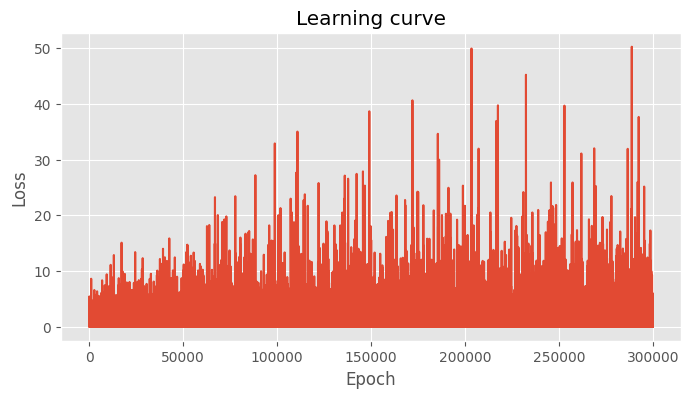

In [45]:
plot_learning_curve(loss_epochs)

Кривая обучения не должна иметь столь высокую вариацию.

Гипотеза: слишком высокое значение learning rate

#### Архитектура-1

In [59]:
class Architecture1MNISTModel(nn.Module):
    def __init__(self, input_size: int, hidden_size_1: int, hidden_size_2: int):
        super(Architecture1MNISTModel, self).__init__()
        self.seq = torch.nn.Sequential(
            nn.Linear(input_size, hidden_size_1),
            nn.Linear(hidden_size_1, hidden_size_2),
            nn.ReLU(),
            nn.Linear(hidden_size_2, 10),
        )

    def forward(self, x):
        return self.seq(x)

In [60]:
# Params
INPUT_SIZE = 28*28
HIDDEN_SIZE_1 = 28*14
HIDDEN_SIZE_2 = 28*7
N_EPOCHS = 10
LR = 0.01

model = Architecture1MNISTModel(INPUT_SIZE, HIDDEN_SIZE_1, HIDDEN_SIZE_2)
model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

train_step = make_train_step(model, loss_fn, optimizer)

loss_epochs = []
for epoch in range(N_EPOCHS):
    for images, labels in train_loader:
        images = images.reshape(-1, 28*28).to(device)
        images = images.to(device)
        labels = labels.to(device)
        loss = train_step(images, labels)
        loss_epochs.append(loss)
    print(epoch)

print(model.state_dict())
print(loss)

0
1
2
3
4
5
6
7
8
9
OrderedDict([('seq.0.weight', tensor([[-0.0112, -0.0352, -0.0224,  ...,  0.0005, -0.0012,  0.0043],
        [-0.0009,  0.0013, -0.0108,  ..., -0.0190,  0.0019,  0.0060],
        [ 0.0191, -0.0052,  0.0178,  ..., -0.0105, -0.0115, -0.0113],
        ...,
        [-0.0008, -0.0325, -0.0227,  ...,  0.0316,  0.0249,  0.0068],
        [ 0.0223,  0.0329, -0.0106,  ..., -0.0286, -0.0016,  0.0278],
        [-0.0242,  0.0021,  0.0356,  ..., -0.0086,  0.0129,  0.0214]],
       device='cuda:0')), ('seq.0.bias', tensor([-0.0045,  0.1274,  0.0393, -0.1451,  0.0227,  0.1147,  0.0042, -0.1295,
         0.0183, -0.1188, -0.0964,  0.0987,  0.0601, -0.0920, -0.0600,  0.1410,
        -0.1446,  0.0772,  0.1878, -0.1152, -0.1033,  0.1035,  0.0340, -0.0780,
        -0.1462,  0.1901, -0.0102, -0.1017,  0.0147,  0.0832, -0.1387, -0.1272,
        -0.0727,  0.1316, -0.1475, -0.2676,  0.0471, -0.0610,  0.0144, -0.1019,
        -0.0481, -0.0632,  0.0299,  0.0932, -0.1585,  0.0357,  0.1837, -0.0

In [61]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Точность: {} %'.format(100 * correct / total))

Точность: 11.35 %


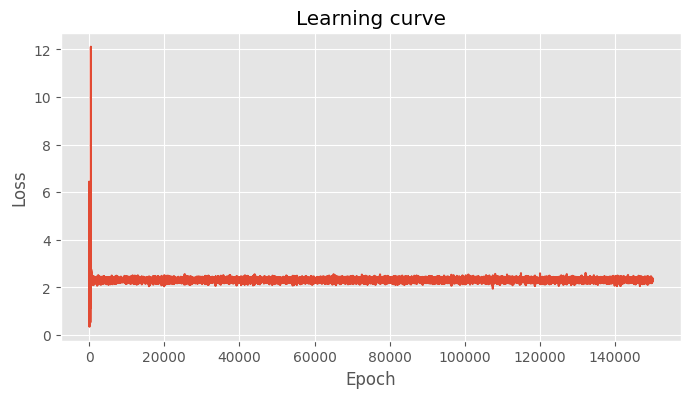

In [62]:
plot_learning_curve(loss_epochs)

#### Архитектура-2

In [69]:
class Architecture2MNISTModel(nn.Module):
    def __init__(self, input_size: int, hidden_size_1: int, hidden_size_2: int):
        super(Architecture2MNISTModel, self).__init__()
        self.seq = torch.nn.Sequential(
            nn.Linear(input_size, hidden_size_1),
            nn.ReLU(),
            nn.Linear(hidden_size_1, hidden_size_2),
            nn.ReLU(),
            nn.Linear(hidden_size_2, 10)
        )

    def forward(self, x):
        return self.seq(x)

In [70]:
# Params
INPUT_SIZE = 28*28
HIDDEN_SIZE_1 = 28*22
HIDDEN_SIZE_2 = 28*10
N_EPOCHS = 10
LR = 0.001

model = Architecture2MNISTModel(INPUT_SIZE, HIDDEN_SIZE_1, HIDDEN_SIZE_2)
model.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

train_step = make_train_step(model, loss_fn, optimizer)

loss_epochs = []
for epoch in range(N_EPOCHS):
    one_epoch_losses = []
    for images, labels in train_loader:
        images = images.reshape(-1, 28*28).to(device)
        images = images.to(device)
        labels = labels.to(device)
        loss = train_step(images, labels)
        one_epoch_losses.append(loss)
    print(epoch)

print(model.state_dict())
print(loss)

0
1
2
3
4
5
6
7
8
9
OrderedDict([('seq.0.weight', tensor([[ 0.0022, -0.0185, -0.0270,  ..., -0.0077,  0.0140, -0.0133],
        [-0.0216, -0.0006,  0.0143,  ...,  0.0290,  0.0121,  0.0338],
        [ 0.0029, -0.0107,  0.0322,  ...,  0.0063, -0.0219,  0.0270],
        ...,
        [ 0.0333,  0.0113, -0.0267,  ..., -0.0034,  0.0249,  0.0335],
        [ 0.0197,  0.0142,  0.0018,  ...,  0.0049, -0.0206,  0.0015],
        [ 0.0331, -0.0219,  0.0202,  ...,  0.0355, -0.0088, -0.0025]],
       device='cuda:0')), ('seq.0.bias', tensor([-1.1277e-02, -5.2142e-03, -5.1943e-02, -1.9029e-01, -2.9277e-01,
        -4.0576e-01, -3.7971e-02, -3.8552e-01, -2.3548e-02, -1.5270e-02,
        -3.0198e-01, -3.4127e-01, -7.2154e-02, -4.7953e-01, -4.6923e-01,
        -3.4686e-01, -1.8990e-01, -5.3524e-03, -1.1634e-01, -3.7367e-01,
        -4.6988e-01, -2.2986e-01, -3.8730e-02, -4.9502e-02, -1.9502e-01,
        -5.6971e-01, -2.2158e-01, -1.2893e-02, -1.3050e-01, -1.8026e-01,
        -3.4022e-01, -2.1148e-01, -5.

In [71]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Точность: {} %'.format(100 * correct / total))

Точность: 97.6 %


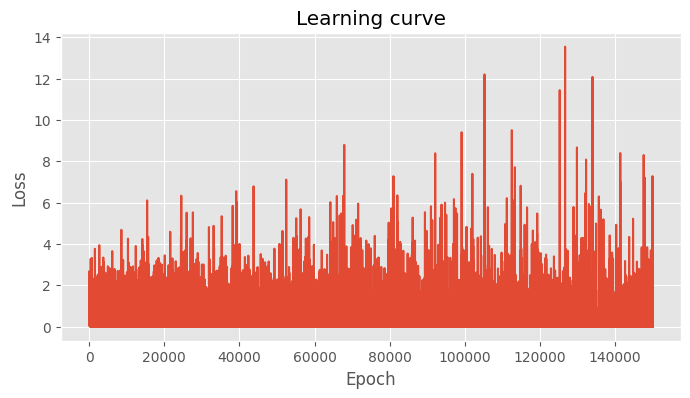

In [73]:
plot_learning_curve(loss_epochs)